In [2]:
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms


from src import preprocess
from src import patient
from src import model
from src import metrics

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = '/workdir/hassony/data'
train_dir = data_dir + '/Training'
save_dir = data_dir + '/storage'

train_df = pd.read_csv('/workdir/hassony/data/Training.csv')

In [4]:
patch_size = 25
patient_patches = preprocess.extract_all_patches(train_dir, patch_size)

In [45]:
print('{nb_patients} had at least one patch of size {patch_size}'.format(nb_patients=len(patient_patches), patch_size=patch_size))
nbs_patch = []
for patient in patient_patches:
    nbs_patch.append(len(patient_patches[patient]))
    
print('{nb_patch} patches were extracted in total'.format(nb_patch=np.sum(nbs_patch)))

97 had at least one patch of size 25
740053 patches were extracted in total


In [ ]:
train_df

In [6]:
pkl.dump(patient_patches, open(save_dir +
                                '/train_patient_patches_size{size}.pkl'.format(size=patch_size),
                                'wb'))
patient_patches = pkl.load( open(save_dir + '/train_patient_patches_size{size}.pkl'.format(size=patch_size), 'rb'))

In [8]:
# Get hpv-positive and hpv-negative patients
pos_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 1)
neg_patients = patient.get_patients_by_rec(train_df, patient_patches.keys(), patient_patches, 0)
print('{0} negative hpv patients'.format(len(neg_patients)))
print('{0} positive hpv patients'.format(len(pos_patients)))

18 negative hpv patients
53 positive hpv patients


In [9]:
# Create a train-test-split with same number of negative and positive hpv patients in each set

# Insure test-train split is consistent
np.random.seed(2)
    
train_list, test_list = model.make_train_test_lists(pos_patients, neg_patients)
print('train patients : {0}'.format(train_list))
print('test patients : {0}'.format(test_list))

train patients : [102, 100, 82, 107, 139, 1, 70, 4, 62, 43, 34, 37, 78, 140, 105, 48, 120, 153, 73, 150, 39, 71, 99, 47, 5, 64, 174, 9, 24, 18, 196, 293, 22, 273, 313]
test patients : [51, 26, 44, 84, 63, 23, 116, 12, 7, 54, 65, 137, 55, 122, 79, 93, 30, 159, 38, 49, 121, 59, 32, 136, 46, 111, 13, 194, 142, 2, 15, 57, 143, 285, 312]


In [13]:
# Extract patches and targets as list of tensors and list of int respectively
train_patches, train_targets = model.create_patch_target(train_list, patient_patches, train_df)
test_patches, test_targets = model.create_patch_target(test_list, patient_patches, train_df)


In [14]:
print('Extracted {patch_nb} patches for training'.format(patch_nb=len(train_patches)))
print('Extracted {patch_nb} patches for testing'.format(patch_nb=len(test_patches)))

Extracted 383955 patches for training
Extracted 353582 patches for testing


In [15]:
mean_patch = model.get_mean_patch(train_patches)

In [57]:
np.mean(mean_patch.numpy())
np.max(mean_patch.numpy())

1101.4235

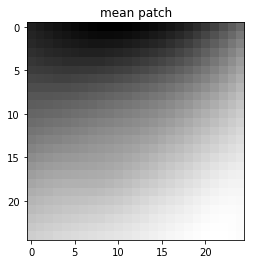

In [55]:
mean_patch
plt.imshow(mean_patch.numpy(), cmap='gray')
plt.title('mean patch')
plt.show()


In [17]:
train_target_tensors, train_patch_tensors = model.create_balanced_tensors(train_targets, train_patches, disp=True)
test_target_tensors, test_patch_tensors = model.create_balanced_tensors(test_targets, test_patches, disp=True)


261056 positive patches
122899 negative patches
115480 positive patches
238102 negative patches


In [18]:
print(train_patch_tensors.size())
print(test_patch_tensors.size())

torch.Size([245798, 1, 25, 25])
torch.Size([230960, 1, 25, 25])


In [19]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(train_patch_tensors, train_target_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(test_patch_tensors, test_target_tensors)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
print(len(train_loader), 'training samples')
print(len(test_loader), 'training samples')

24580 training samples
23096 training samples


In [20]:
class Net(nn.Module):
    """
    takes patches of size 25 as input
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x , 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [21]:
def train_net(dataloader, net, loss_criterion, mean_patch, optimizer, learn=True):
    running_loss = 0.0
    prediction = []
    target = []
    for i, data_item in enumerate(dataloader, 0):
        if (i<400):
            # get the inputs
            inputs, labels = data_item

            # Remove mean patch from current patch
            inputs = inputs - mean_patch.repeat(inputs.size()[0], 1, 1, 1)
            labels = labels.squeeze()
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            for label in labels:
                if(label.data[0]==1):
                    target.append(1)
                else:
                    target.append(0)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
            loss = loss_criterion(outputs, labels)

            # if learning  backward + optimize
            if (learn):
                loss.backward()        
                optimizer.step()

            running_loss += loss.data[0]
            
            
            for output in outputs:
                if(output.data[0]>0.5):
                    prediction.append(1)
                else:
                    prediction.append(0)
            
            # If network currently learning

    return prediction, target, running_loss


In [27]:
def simulation(dataloader, test_dataloader, net, loss_criterion, mean_patch, epochNb, learning_rate):
    
    # Initialize performance arrays
    train_losses = np.zeros(epochNb)
    train_accuracies = np.zeros(epochNb)
    test_losses = np.zeros(epochNb)
    test_accuracies = np.zeros(epochNb)

    train_learning = False
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochNb): # loop over the dataset multiple times
        if (epoch>0):
            train_learning = True

        # train
        prediction, target, train_loss = train_net(dataloader, net, loss_criterion, mean_patch,
                                                   optimizer, learn=train_learning)
        train_conf_mat, train_acc = metrics.get_metrics(target, prediction)
        train_losses[epoch] = train_loss

        # Save results
        train_accuracies[epoch] = train_acc
        train_losses[epoch] = train_loss
        
        # print epoch train results
        print('Training loss: {los}'.format(los=train_loss))
        print('Training confusion matrix')
        print(train_conf_mat)
        print('Training accuracy : ', train_acc) 

        # test
        test_prediction, test_target, test_loss = train_net(test_dataloader, net, loss_criterion, mean_patch,
                                                            optimizer, learn=False)
        test_conf_mat, test_acc = metrics.get_metrics(test_target, test_prediction)
        test_losses[epoch] = test_loss

        # Save results
        test_accuracies[epoch] = test_acc
        test_losses[epoch] = test_loss
        
        # print epoch train results
        print('Testing loss: {los}'.format(los=test_loss))
        print('Testing confusion matrix')
        print(test_conf_mat)
        print('Testing accuracy : ', test_acc) 
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [54]:
torch.manual_seed(2)
model = Net()

bce_criterion = nn.BCELoss()
epoch = 50
learning_rate = 0.0000001
momentum = 0.9
train_losses, test_losses, train_accuracies, test_accuracies = simulation( test_loader, train_loader, model, bce_criterion, mean_patch, epoch, learning_rate)

Training loss: 552.4153308868408
Training confusion matrix
[[  740.   542.]
 [ 1307.  1411.]]
Training accuracy :  0.53775
Testing loss: 582.0201032757759
Testing confusion matrix
[[  530.   655.]
 [ 1500.  1315.]]
Testing accuracy :  0.46125
Training loss: 537.7623874843121
Training confusion matrix
[[  746.   635.]
 [ 1272.  1347.]]
Training accuracy :  0.52325
Testing loss: 527.3392508327961
Testing confusion matrix
[[  625.   821.]
 [ 1359.  1195.]]
Testing accuracy :  0.455
Training loss: 494.74034264683723
Training confusion matrix
[[  843.   671.]
 [ 1186.  1300.]]
Training accuracy :  0.53575
Testing loss: 505.70334178209305
Testing confusion matrix
[[  735.   906.]
 [ 1297.  1062.]]
Testing accuracy :  0.44925
Training loss: 483.42548111081123
Training confusion matrix
[[  917.   732.]
 [ 1160.  1191.]]
Training accuracy :  0.527
Testing loss: 460.2545104920864
Testing confusion matrix
[[  815.   985.]
 [ 1179.  1021.]]
Testing accuracy :  0.459
Training loss: 445.666815280914

KeyboardInterrupt: 

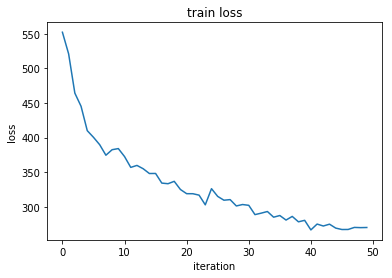

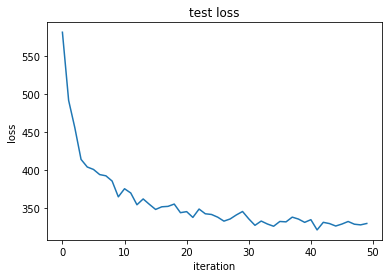

In [51]:
plt.plot(train_losses)
plt.title('train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(test_losses)
plt.title('test loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

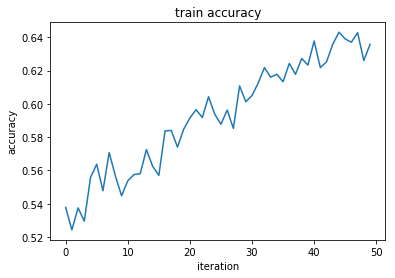

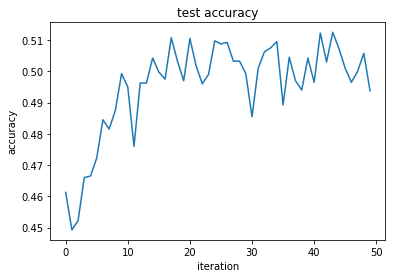

In [52]:
plt.plot(train_accuracies)
plt.title('train accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()
plt.plot(test_accuracies)
plt.title('test accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

In [ ]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
prediction_, target_, loss_ = train_net(test_loader, model, bce_criterion, mean_patch,  optimizer, learn=False)
metrics.get_metrics(target_, prediction_)